In [ ]:
!/opt/conda/envs/hunyuan_venv/bin/python -m pip install pytorch3d
!/opt/conda/envs/hunyuan_venv/bin/python -m pip install pyrender
!/opt/conda/envs/hunyuan_venv/bin/python -m pip install shapely
!/opt/conda/envs/hunyuan_venv/bin/python -m pip install trimesh[easy]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [14]:
import trimesh
import pytorch3d
import pyrender
import shapely
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon, Point

In [ ]:
mesh_path = '~/project_2_3d_human/Hunyuan3D-2/egor2_mesh.glb'

In [16]:
mesh = trimesh.load(mesh_path, force='mesh')
true_height = 200
scale_factor = true_height / mesh.extents[1]
mesh.apply_scale(scale_factor)
mesh.show()

In [17]:
print('\tThickness\tHeight\tWidth\n', mesh.extents)

	Thickness	Height	Width
 [ 55.48120643 200.          39.93781101]


In [18]:
bounds = mesh.bounds  # [[min_x, min_y, min_z], [max_x, max_y, max_z]]
print(bounds)
min_x, min_y, min_z = bounds[0]
max_x, max_y, max_z = bounds[1]

num_slices = 6
# Разбиваем диапазон Y на 8 равных слайсов
y_slices = np.linspace(min_y, max_y, num_slices + 1)

# Список для хранения частей модели
sliced_parts = []

# Для каждого слайса создаем ограничивающий бокс и пересекаем его с исходным мешем
for i in range(num_slices):
    slice_min_y = y_slices[i]
    slice_max_y = y_slices[i+1]
    
    # Создаем боксовый меш, который полностью покрывает диапазоны по X и Z, 
    # а по Y ограничен slice_min_y и slice_max_y.
    box_extents = np.array([
        max_x - min_x,  # размер по X
        slice_max_y - slice_min_y,  # размер по Y (для слайса)
        max_z - min_z   # размер по Z
    ])
    box_center = np.array([
        (max_x + min_x) / 2,
        (slice_max_y + slice_min_y) / 2,
        (max_z + min_z) / 2
    ])
    
    box = trimesh.creation.box(extents=box_extents, transform=trimesh.transformations.translation_matrix(box_center))
    
    # Выполняем булевое пересечение (intersection) меша и бокса
    slice_mesh = trimesh.boolean.intersection([mesh, box], engine="manifold")
    
    if slice_mesh is not None and len(slice_mesh.vertices) > 0:
        sliced_parts.append(slice_mesh)
        # Можно сохранить каждую часть:
        slice_mesh.export(f"slice_{i+1}.glb")
    else:
        print(f"Слайс {i+1} пустой или не удалось вычислить пересечение.")

print(f"Модель успешно разделена на {num_slices} частей по оси Y с помощью булевых операций!")

[[ -27.97611901 -100.25891778  -19.79354158]
 [  27.50508742   99.74108222   20.14426943]]
Модель успешно разделена на 6 частей по оси Y с помощью булевых операций!


In [21]:
submesh_path = '~/project_2_3d_human/Model_evaluation/slice_3.glb'
submesh = trimesh.load(submesh_path, force='mesh')
submesh.show()

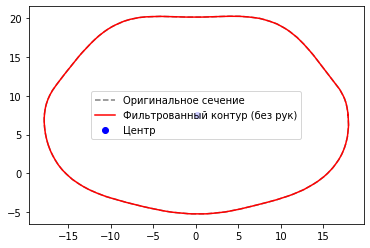

Обхват бедер (без рук) = 98.21


In [ ]:

shoulders_y = slice_mesh.bounds[1][1] - 0.
slice_2D, _ = slice_mesh.section([0, 1, 0], [0, shoulders_y, 0]).to_2D()

polygon = max(slice_2D.polygons_full, key=lambda p: p.area)
center = np.array(polygon.centroid.coords)[0]  # [x, y]

vertices = np.array(polygon.exterior.coords)
max_radius = np.max(np.linalg.norm(vertices - center, axis=1)) * 1.5

num_rays = 360
angles = np.linspace(0, 2 * np.pi, num_rays)

filtered_points = []

for angle in angles:

    end_x = center[0] + max_radius * np.cos(angle)
    end_y = center[1] + max_radius * np.sin(angle)
    ray = LineString([center, (end_x, end_y)])
    
    intersections = polygon.exterior.intersection(ray)

    if intersections.is_empty:
        continue
    elif intersections.geom_type == 'Point':
        filtered_points.append((intersections.x, intersections.y))
    elif intersections.geom_type in ['MultiPoint', 'LineString']:
        if intersections.geom_type == 'LineString':
            points = list(intersections.coords)
            points = [Point(pt) for pt in points]
        else:
            points = list(intersections.geoms)
        first_point = min(points, key=lambda p: Point(center).distance(p))
        filtered_points.append((first_point.x, first_point.y))

filtered_polygon = Polygon(filtered_points)

fig, ax = plt.subplots()
ax.plot(*polygon.exterior.xy, color="gray", linestyle="--", label="Оригинальное сечение")
ax.plot(*filtered_polygon.exterior.xy, color="r", label="Фильтрованный контур (без рук)")
ax.scatter(center[0], center[1], color="blue", label="Центр")
plt.legend()
plt.show()

hip_circumference = filtered_polygon.length
print(f"Обхват бедер (без рук) = {hip_circumference:.2f}")
